In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.fft
import cv2
from PIL import Image

# Filtrado de imágenes

En esta lección veremos:

- Filtrado con máscaras en frecuencia
- Filtrado con convolución 2D


## Filtro en frecuencia

Recordemos que, por propiedad de la transformada de Fourier

:::{important}

Una multiplicación en el espacio de frecuencia equivale a una convolución en el espacio original

:::

Podemos usar esta propiedad para hacer filtrado

- Calculamos el espectro de la imagen usando la DFT
- Multiplicamos el espectro por una ventana
- Aplicamos DFT inversa para obtener la imagen filtrada



**Ejemplo:** Filtro pasa-bajos

Usamos opencv para calcular la transformada de Fourier de la siguiente imagen

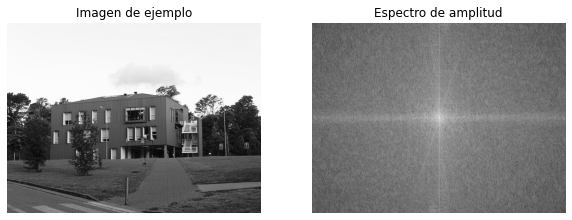

In [2]:
inst = cv2.cvtColor(cv2.imread('data/InsInformatica.jpg'), cv2.COLOR_BGR2GRAY)
inst_dft = cv2.dft(np.float32(inst), flags=cv2.DFT_COMPLEX_OUTPUT)
inst_magnitude, inst_phase = cv2.cartToPolar(inst_dft[:,:,0], inst_dft[:,:,1])

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(inst, cmap=plt.cm.Greys_r)
ax[0].axis('off')
ax[0].set_title('Imagen de ejemplo')
ax[1].imshow(scipy.fft.fftshift(1+np.log(inst_magnitude)), cmap=plt.cm.Greys_r)
ax[1].axis('off');
ax[1].set_title('Espectro de amplitud');

Multipliquemos el espectro por una ventana rectangular que multiplique por cero las frecuencias altas

:::{important}

Eliminar las frecuencias altas tiene un efecto de suavizado en la imagen original

:::

Luego tomamos la transformada de Fourier inversa del espectro multiplicado para obtener una imagen filtrada.




Observe como cambia el resultado a medida que disminuimos progresivamente el tamaño de la ventana (`sigma`)

In [3]:
def reconstruct(mag, phase):
    return cv2.dft(cv2.merge([*cv2.polarToCart(mag, phase)]), 
                  flags=cv2.DFT_INVERSE | cv2.DFT_REAL_OUTPUT | cv2.DFT_SCALE)

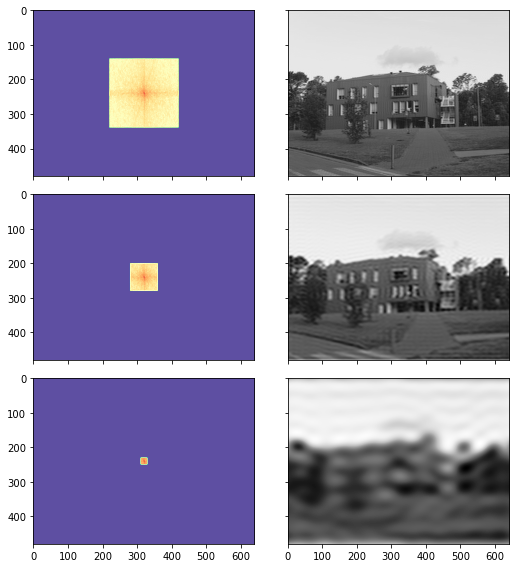

In [4]:
def create_mask(img_shape, sigma):
    cy, cx = img_shape[0]/2, img_shape[1]/2
    x = np.arange(0, img_shape[1]); 
    y = np.arange(0, img_shape[0]);
    X, Y = np.meshgrid(x, y)
    mask = np.zeros(shape=img_shape, dtype=np.float32)
    mask[int(cy-sigma):int(cy+sigma), 
         int(cx-sigma):int(cx+sigma)] = 1
    return mask

fig, ax = plt.subplots(3, 2, figsize=(8, 8), tight_layout=True, sharex=True, sharey=True);
for i, sigma in enumerate([100, 40, 10]):
    espectro_filtrado = scipy.fft.fftshift(inst_magnitude)*create_mask(inst.shape, sigma)
    ax[i, 0].imshow(np.log(1+np.abs(espectro_filtrado)), cmap=plt.cm.Spectral_r)
    image_reconstruida = reconstruct(scipy.fft.ifftshift(espectro_filtrado), inst_phase)
    ax[i, 1].imshow(image_reconstruida, cmap=plt.cm.Greys_r)    

Este procedimiento puede usarse para eliminar ruido a costa de perder detalles

Para evitar artefactos causados por los bordes abruptos de la señal rectangular podemos reemplazar la misma por una ventana Gaussiana. Esta operación se suele llamar "suavizado gaussiano" 

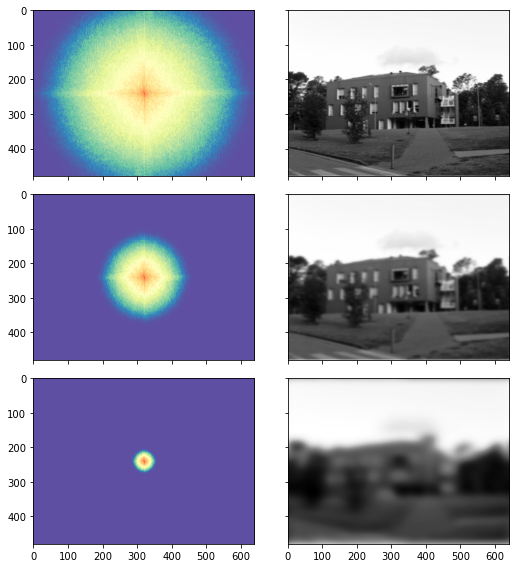

In [5]:
def create_mask(img_shape, sigma):
    cy, cx = img_shape[0]/2, img_shape[1]/2
    x = np.arange(0, img_shape[1]); 
    y = np.arange(0, img_shape[0]);
    X, Y = np.meshgrid(x, y)    
    return 1e-8 + np.exp(-(((X-cx)/sigma)**2 + ((Y-cy)/sigma)**2)).astype('float32')

fig, ax = plt.subplots(3, 2, figsize=(8, 8), tight_layout=True, sharex=True, sharey=True);
for i, sigma in enumerate([100, 40, 10]):
    espectro_filtrado = scipy.fft.fftshift(inst_magnitude)*create_mask(inst.shape, sigma)
    ax[i, 0].imshow(np.log(1+np.abs(espectro_filtrado)), cmap=plt.cm.Spectral_r)
    image_reconstruida = reconstruct(scipy.fft.ifftshift(espectro_filtrado), inst_phase)
    ax[i, 1].imshow(image_reconstruida, cmap=plt.cm.Greys_r)

**Ejemplo:** Filtro pasa-altos

Si usamos el inverso de una ventana gaussiana entonces estaríamos multiplicando por cero las frecuencias más bajas. Esto borra los colores, dejándo sólo los detalles o bordes

Observe como cambia el resultado a medida que borramos más frecuencias bajas

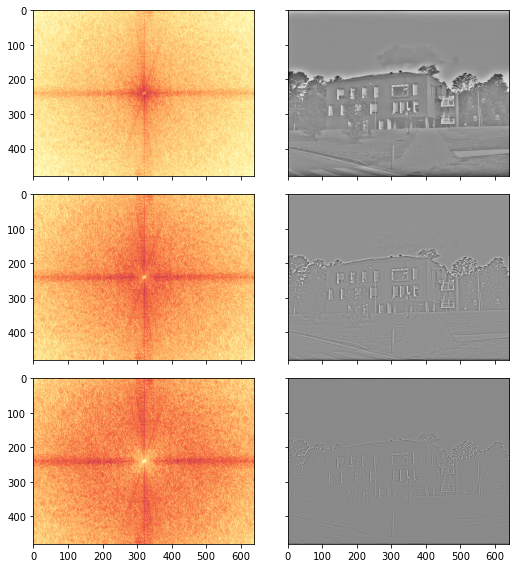

In [6]:
def create_mask(img_shape, sigma):
    cy, cx = img_shape[0]/2, img_shape[1]/2
    x = np.arange(0, img_shape[1]); 
    y = np.arange(0, img_shape[0]);
    X, Y = np.meshgrid(x, y)    
    return 1.0  - np.exp(-(((X-cx)/sigma)**2 + ((Y-cy)/sigma)**2)).astype('float32')

fig, ax = plt.subplots(3, 2, figsize=(8, 8), tight_layout=True, sharex=True, sharey=True);
for i, sigma in enumerate([10, 40, 100]):
    espectro_filtrado = scipy.fft.fftshift(inst_magnitude)*create_mask(inst.shape, sigma)
    ax[i, 0].imshow(np.log(1+np.abs(espectro_filtrado)), cmap=plt.cm.Spectral_r)
    image_reconstruida = reconstruct(scipy.fft.ifftshift(espectro_filtrado), inst_phase)
    ax[i, 1].imshow(image_reconstruida, cmap=plt.cm.Greys_r)

## Filtrado en el dominio de la imagen

También es posible filtrar una imagen directamente en el espacio original usando la convolución bidimensional. 

El elemento que se convoluciona con la imagen se denomina filtro o kernel de convolución

La siguiente animación muestra el proceso de convolución en dos dimensiones

<img src="images/filter2D_convolution.gif" width="600">


¿Qué cree usted que hacen estos los siguientes kernels/filtros?

$$
\begin{pmatrix}
1 & 1 & 1 & 1 & 1 \\
1 & 1 & 1 & 1 & 1 \\
1 & 1 & 1 & 1 & 1 \\
1 & 1 & 1 & 1 & 1 \\
1 & 1 & 1 & 1 & 1 \\
\end{pmatrix} \frac{1}{25} 
\qquad
\begin{pmatrix}
0.018 & 0.082 & 0.1353 & 0.082 & 0.018 \\
0.082 & 0.3678 & 0.6065 & 0.3678 & 0.082 \\
0.1353 & 0.6065 & 1 & 0.6065 & 0.1353 \\
0.082 & 0.3678 & 0.6065 & 0.3678 & 0.082 \\
0.018 & 0.082 & 0.1353 & 0.082 & 0.018 \\
\end{pmatrix} \frac{1}{\sqrt{2\pi}}
$$

> Ambos son filtros promediadores, es decir que reemplazan cada pixel por un promedio de sus vecinos. Estos filtros actuan como pasa-bajos ya que suavizan la imagen.


Con OpenCV se puede filtrar con la función `filter2D` la cual recibe como argumentos

- `src`: La imagen que se quiere filtrar
- `Kernel`: El filtro con que se desea convolucionar
- `ddepth`: Profundidad o número de canales de la imagen resultante, se puede usar `-1` para forzar la misma profundidad de `src`

**Ejemplo:** Filtro rectangular promediador

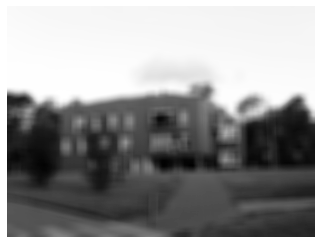

In [7]:
size = 20
kernel = np.ones(shape=(size, size))/size**2

fig, ax = plt.subplots(figsize=(5, 3.5), tight_layout=True);
ax.imshow(cv2.filter2D(src=inst, ddepth=-1, kernel=kernel), cmap=plt.cm.Greys_r)
ax.axis('off');

**Ejemplo:** Detección de borde con filtro Sobel

Los siguientes filtros se conocen como sobel horizontal y vertical

In [8]:
sobel_v = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
sobel_h = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])

Se utilizan para resaltar los bordes de la imagen

In [9]:
filtered_v = cv2.filter2D(src=inst.astype('float32'), ddepth=-1, kernel=sobel_v)
filtered_h = cv2.filter2D(src=inst.astype('float32'), ddepth=-1, kernel=sobel_h)

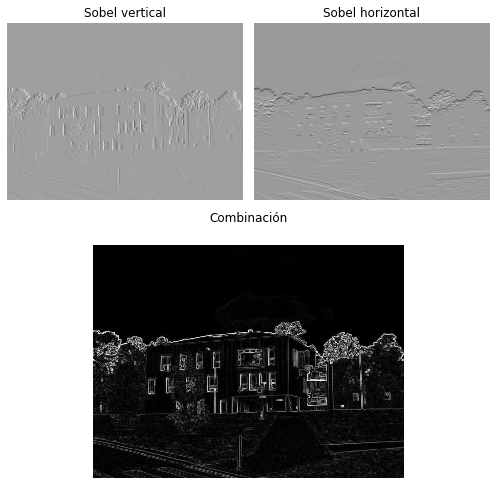

In [10]:
fig, ax = plt.subplots(figsize=(7, 7), tight_layout=True);
ax =  plt.subplot2grid((2, 2), (0, 0))
ax.imshow(filtered_v, cmap=plt.cm.Greys_r); 
ax.axis('off')
ax.set_title('Sobel vertical')
ax = plt.subplot2grid((2, 2), (0, 1))
ax.imshow(filtered_h, cmap=plt.cm.Greys_r)
ax.axis('off')
ax.set_title('Sobel horizontal')
ax = plt.subplot2grid((2, 2), (1, 0), colspan=2)
ax.matshow(np.sqrt(filtered_v**2 + filtered_h**2)[3:-3,3:-3], cmap=plt.cm.Greys_r)
ax.axis('off')
ax.set_title('Combinación');

## Ruido en imágenes

Existen distintos tipos de ruido que pueden afectar una imagen

- Ruido térmico, ruido de lectura, ruido eléctronico: Se modelan tipicamente como **ruido blanco Gaussiano**
- Ruido sal y pimienta o **Ruido impulsivo**: Se traduce en píxeles que se saturan en sus valores máximos/mínimos
- Interferencia periódica: Puede modelarse como una sinusoide

A continuación mostraremos como se ven estos ruidos para aprender a reconocerlos

También veremos como disminuir sus efectos usando filtros

Considere la siguiente imagen de ejemplo:

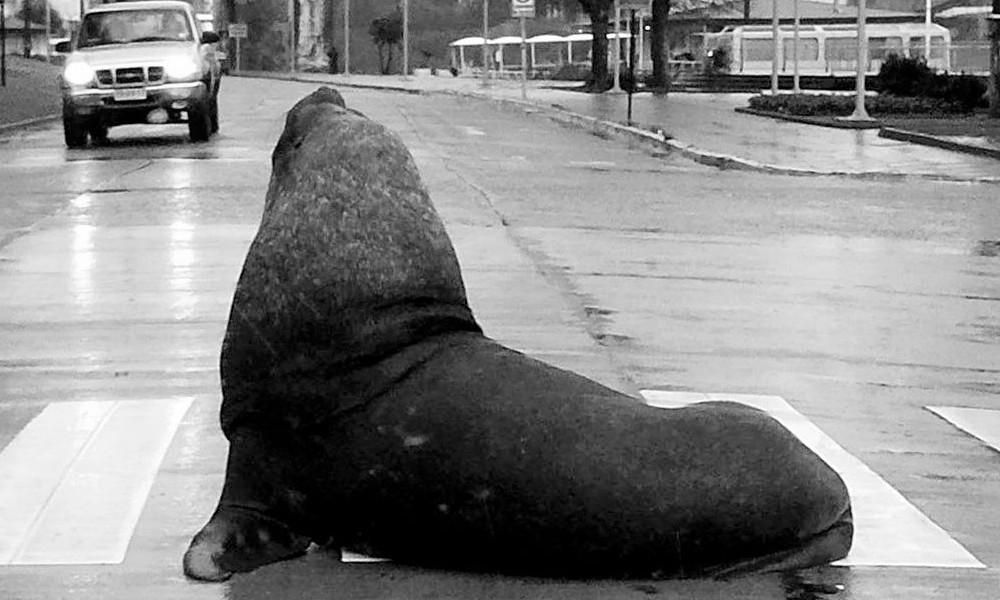

In [11]:
lobo = cv2.cvtColor(cv2.imread('data/lobo.jpg'), cv2.COLOR_BGR2GRAY)
Image.fromarray(lobo)

Así se vería si la corrompemos añadiendo ruido blanco gaussiano con una desviación estándar de $20$

In [12]:
sigma = 20
noise = np.random.randn(lobo.shape[0], lobo.shape[1])
lobo_corrupted = lobo + sigma*noise

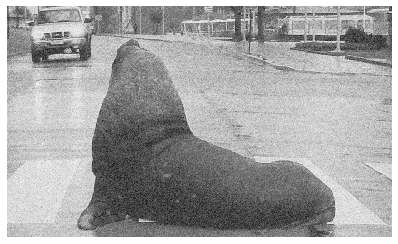

In [13]:
fig, ax = plt.subplots(figsize=(6, 3.5), tight_layout=True)
ax.matshow(lobo_corrupted, cmap=plt.cm.Greys_r)
ax.axis('off');

El ruido blanco se presenta en todo el espectro. Por ende no es posible eliminarlo completamente pero podemos disminuir su efecto usando un filtro pasabajo

Para llegar a un buen resultado se debe calibrar el tamaño del filtro. En este caso particular un filtro rectangular de tamaño $5$ entrega un resultado aceptable

In [14]:
size = 5
kernel = np.ones(shape=(size, size))/size**2
lobo_filtered = cv2.filter2D(src=lobo_corrupted, ddepth=-1, kernel=kernel) 

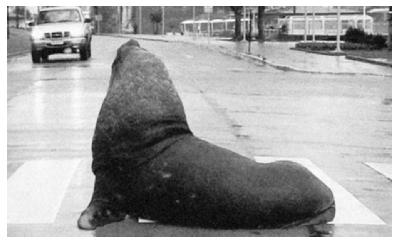

In [15]:
fig, ax = plt.subplots(figsize=(6, 3.5), tight_layout=True)
ax.matshow(lobo_filtered, cmap=plt.cm.Greys_r)
ax.axis('off');

**Ejemplo:** Eliminar ruido impulsivo

El ruido impulso o ruido sal y pimienta aparece como pixeles saturados en la imagen

Un filtro tipicamente usando para disminuir este ruido es el filtro mediana. Si se aplica la mediana en una vecindad los valores extremos serán ignorados

La función `medianBlur` de opencv implementa el filtro mediana y recibe la imagen a filtrar y el tamaño de vecindad del filtro

In [16]:
noise = np.random.rand(*lobo.shape)
lobo_corrupted  = np.where(noise < 0.1, 255, lobo)

In [17]:
lobo_filtered = cv2.medianBlur(lobo_corrupted, 5)

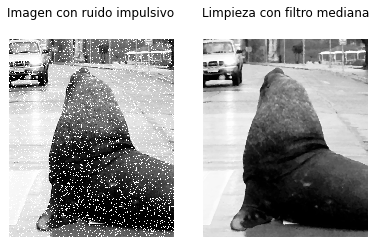

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(6, 3.5), tight_layout=True, sharex=True, sharey=True)
ax[0].matshow(lobo_corrupted[:, 100:600], cmap=plt.cm.Greys_r)     
ax[0].set_title('Imagen con ruido impulsivo')
ax[0].axis('off')
ax[1].matshow(lobo_filtered[:, 100:600], cmap=plt.cm.Greys_r)
ax[1].set_title('Limpieza con filtro mediana')
ax[1].axis('off');